In [12]:
import json
import os, sys
sys.path.insert(0, '/cluster/home/kamara/Explain')
sys.path.insert(0, '/cluster/home/kamara/Explain/code')
import random

import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt


import code
from dataset.gen_mutag import build_mutag
from dataset.gen_syn import build_syndata
from dataset.mutag_utils import data_to_graph
from evaluate.accuracy import eval_accuracy
from evaluate.fidelity import eval_fidelity, eval_related_pred_gc, eval_related_pred_nc
from evaluate.mask_utils import clean_masks, get_size, get_sparsity, normalize_all_masks, transform_mask
from explainer.genmask import compute_edge_masks_gc, compute_edge_masks_nc
from gnn.eval import gnn_scores_gc, gnn_scores_nc
from gnn.model import GcnEncoderGraph, GcnEncoderNode
from gnn.train import train_graph_classification, train_node_classification
from utils.gen_utils import get_test_graphs, get_test_nodes
from utils.graph_utils import get_edge_index_set
from utils.io_utils import check_dir, create_data_filename, create_model_filename, load_ckpt, save_checkpoint
from utils.parser_utils import arg_parse, get_data_args


In [58]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
print(plt.get_backend())

module://matplotlib_inline.backend_inline


In [172]:
def main_syn(args):
    random.seed(args.seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### Generate, Save, Load data 
    data = build_syndata(args)

    ### Create, Train, Save, Load GNN model ###
    model = GcnEncoderNode(
            args.input_dim,
            args.hidden_dim,
            args.output_dim,
            args.num_classes,
            args.num_gc_layers,
            args=args,
            device=device,
        )
    train_node_classification(model, data, device, args)
    model.eval()
    results_train, results_test = gnn_scores_nc(model, data)
    model.to(device)
    print("__gnn_train_scores: " + json.dumps(results_train))
    print("__gnn_test_scores: " + json.dumps(results_test))

    ### Explain ###
    list_test_nodes = get_test_nodes(data, model, args)
    edge_masks, Time = compute_edge_masks_nc(list_test_nodes, model, data, device, args)
    plot_mask_density(edge_masks, args)
    ### Mask transformation ###
    # Replace Nan by 0, infinite by 0 and all value > 10e2 by 10e2
    edge_masks = [edge_mask.astype("float") for edge_mask in edge_masks]
    edge_masks = clean_masks(edge_masks)

    # Normalize edge_masks to have value from 0 to 1
    edge_masks = normalize_all_masks(edge_masks)
    
    
    infos = {
        "dataset": args.dataset,
        "explainer": args.explainer_name,
        "number_of_edges": data.edge_index.size(1),
        "mask_sparsity_init": get_sparsity(edge_masks),
        "non_zero_values_init": get_size(edge_masks),
        "sparsity": args.sparsity,
        "threshold": args.threshold,
        "topk": args.topk,
        "num_test": args.num_test,
        "groundtruth target": args.true_label,
        "time": float(format(np.mean(Time), ".4f")),
    }
    print("__infos:" + json.dumps(infos))

    ### Accuracy Top ###
    accuracy_top = eval_accuracy(data, edge_masks, list_test_nodes, args, top_acc=True)
    print("__accuracy_top:" + json.dumps(accuracy_top))

    ### Mask transformation ###
    edge_masks = transform_mask(edge_masks, args)

    ### Accuracy ###
    accuracy = eval_accuracy(data, edge_masks, list_test_nodes, args, top_acc=False)
    print("__accuracy:" + json.dumps(accuracy))

    ### Fidelity ###
    related_preds = eval_related_pred_nc(model, data, edge_masks, list_test_nodes, device)
    fidelity = eval_fidelity(related_preds)
    print("__fidelity:" + json.dumps(fidelity))

    return edge_masks



In [173]:
import networkx as nx
import numpy as np
import torch
from captum.attr import IntegratedGradients, LayerGradCam, Saliency
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_networkx

from explainer.gnnexplainer import TargetedGNNExplainer
from explainer.pgmexplainer import Node_Explainer
from explainer.subgraphx import SubgraphX

def explain_gnnexplainer(model, node_idx, x, edge_index, target, device, args, include_edges=None):
    explainer = TargetedGNNExplainer(model, num_hops=args.num_gc_layers, epochs=args.num_epochs, edge_ent=args.edge_ent)
    if eval(args.explain_graph):
        edge_mask = explainer.explain_graph_with_target(x=x, edge_index=edge_index, target=target)
    else:
        edge_mask = explainer.explain_node_with_target(node_idx, x=x, edge_index=edge_index, target=target)
    edge_mask = edge_mask.cpu().detach().numpy()
    return edge_mask


In [180]:
from torch.optim.lr_scheduler import StepLR

args = {"dataset": "syn1", "input_dim":1, "val_ratio": 0.15, "test_ratio": 0.1, "train_ratio": 0.8, 'method':'base', 'seed': 10,
       "threshold": -1, "sparsity": -1, "topk":-1, "hidden_dim":20, "output_dim":20, "lr":0.001, "weight_decay":0.005, "true_label":"True",
       "num_basis":300, "num_shapes":150, "opt":"adam", "explainer_name":"gnnexplainer", "explain_graph":"False"}
args['num_top_edges']=6
args['num_test'] = 10
args['num_gc_layers']=3
args['num_epochs']=1000
args["feature_type"] = "default"
args["batch_size"] = 20
args['num_workers'] = 1
args['clip']=2.0
args['num_classes']=4
args['edge_ent'] = 10
#args['edge_size'] = 0

class AttributeDict(dict):
    __slots__ = () 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    
    
args = AttributeDict(args)

__gnn_train_scores: {"prec": 0.8286255411255411, "recall": 0.7604140208280417, "acc": 0.8822429906542056}
__gnn_test_scores: {"prec": 0.6447368421052632, "recall": 0.7291666666666666, "acc": 0.8714285714285714}


Explain node 303:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 799/1000 [00:01<00:00, 401.66it/s]
/cluster/apps/nss/gcc-8.2.0/python/3.8.5/x86_64/lib64/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


__infos:{"dataset": "syn1", "explainer": "gnnexplainer", "number_of_edges": 4110, "mask_sparsity_init": 0.9206326034063261, "non_zero_values_init": 326.2, "sparsity": -1, "threshold": -1, "topk": -1, "num_test": 10, "groundtruth target": "True", "time": 2.1124}
__accuracy_top:{"recall": 0.3, "precision": 0.32666666666666666, "f1_score": 0.31212121212121213}
__accuracy:{"recall": 1.0, "precision": 0.35094123968320856, "f1_score": 0.4440640652649406}
__fidelity:{"fidelity_acc+": 0.4, "fidelity_acc-": 0.0, "fidelity_prob+": 0.29758355021476746, "fidelity_prob-": 0.0, "mask_sparsity": 0.9206326603889465, "expl_edges": 326.2}


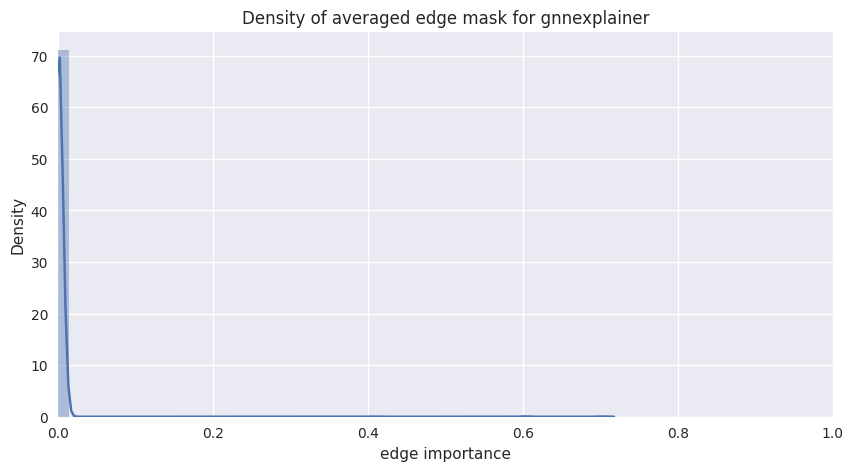

In [181]:
edge_masks = main_syn(args)

In [137]:
def plot_mask_density(edge_masks, args):
    rank_masks = [np.sort(edge_mask) for edge_mask in edge_masks]
    avg_mask = np.mean(rank_masks, axis=0)

    matplotlib.style.use("seaborn")
    plt.switch_backend("agg")
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)
    sns.distplot(avg_mask, kde=True, ax=ax)
    plt.xlim(0,1)
    plt.title(f"Density of averaged edge mask for {args.explainer_name}")
    plt.xlabel("edge importance")
    #plt.savefig(utils.io_utils.gen_mask_density_plt_name(args), dpi=600)
    plt.show()
    #plt.close()
    matplotlib.style.use("default")
    

/cluster/apps/nss/gcc-8.2.0/python/3.8.5/x86_64/lib64/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/cluster/apps/nss/gcc-8.2.0/python/3.8.5/x86_64/lib64/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/cluster/apps/nss/gcc-8.2.0/python/3.8.5/x86_64/lib64/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

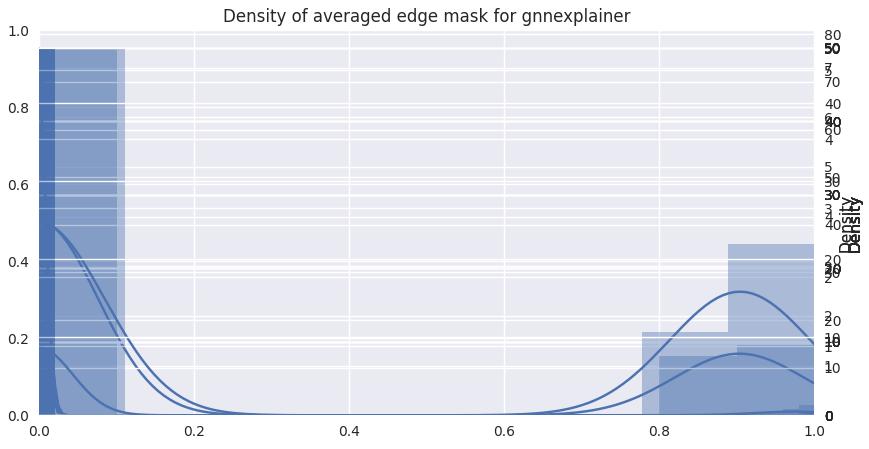

In [182]:
# Entropy = 10

matplotlib.style.use("seaborn")
plt.switch_backend("agg")
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

for edge_mask in edge_masks:
    ax2 = ax.twinx()
    sns.distplot(edge_mask, kde=True, ax=ax2)
    
plt.xlim(0,1)
plt.title(f"Density of averaged edge mask for {args.explainer_name}")
plt.xlabel("edge importance")
plt.savefig('fig_size_0.005_ent_10.png', dpi=600)
plt.show()
#plt.close()
matplotlib.style.use("default")